In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, roc_auc_score, roc_curve, classification_report

import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from catboost import Pool


pd.set_option('display.max_columns', None)

In [39]:
#Get columns from the metadata file
columns = [
    'age',
    'class_of_worker',
    'detailed_industry_recode',
    'detailed_occupation_recode',
    'education',
    'wage_per_hour',
    'enroll_in_edu_inst_last_wk',
    'marital_stat',
    'major_industry_code',
    'major_occupation_code',
    'race',
    'hispanic_origin',
    'sex',
    'member_of_a_labor_union',
    'reason_for_unemployment',
    'full_or_part_time_employment_stat',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks',
    'tax_filer_stat',
    'region_of_previous_residence',
    'state_of_previous_residence',
    'detailed_household_and_family_stat',
    'detailed_household_summary_in_household',
    'instance weight',
    'migration_code_change_in_msa',
    'migration_code_change_in_reg',
    'migration_code_move_within_reg',
    'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt',
    'num_persons_worked_for_employer',
    'family_members_under_18',
    'country_of_birth_father',
    'country_of_birth_mother',
    'country_of_birth_self',
    'citizenship',
    'own_business_or_self_employed',
    'fill_inc_questionnaire_for_veterans_admin',
    'veterans_benefits',
    'weeks_worked_in_year',
    'year',
    'total_person_income'
]


### Load the Data

In [40]:
data_learn=pd.read_csv('census_income_learn.csv', names=columns, header=0)
data_test=pd.read_csv('census_income_test.csv', names=columns, header=0)

In [41]:
data=pd.concat([data_learn, data_test], ignore_index=True)

## Exploratory Data Analysis (EDA)

In [6]:
# Check the number of Null values/? marks
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
question_mark_count = (data == '?').sum()

In [7]:
question_mark_count

age                                               0
class_of_worker                                   0
detailed_industry_recode                          0
detailed_occupation_recode                        0
education                                         0
wage_per_hour                                     0
enroll_in_edu_inst_last_wk                        0
marital_stat                                      0
major_industry_code                               0
major_occupation_code                             0
race                                              0
hispanic_origin                                   0
sex                                               0
member_of_a_labor_union                           0
reason_for_unemployment                           0
full_or_part_time_employment_stat                 0
capital_gains                                     0
capital_losses                                    0
dividends_from_stocks                             0
tax_filer_st

In [6]:
# Modifying data types

data['year'] = data['year'].astype('object')
data['veterans_benefits'] = data['veterans_benefits'].astype('object')
data['own_business_or_self_employed'] = data['own_business_or_self_employed'].astype('object')
data['detailed_industry_recode'] = data['detailed_industry_recode'].astype('object')
data['detailed_occupation_recode'] = data['detailed_occupation_recode'].astype('object')
data['weeks_worked_in_year'] = data['weeks_worked_in_year'].astype('object')

In [7]:
# Count all duplicated rows
duplicate_count = data.duplicated().sum()

In [71]:
# Display the number of duplicated rows
print("Number of duplicated rows in data:", duplicate_count)


Number of duplicated rows in data: 6735


In [42]:
full_data=data.drop_duplicates()

#### Check Correlation between categorical variables

In [ ]:
# Create a function to calculate Cramér's correlation
def cramers_v(x, y):
    crosstab = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    n = crosstab.sum().sum()
    phi2 = chi2 / n
    r, k = crosstab.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

In [13]:
categorical_columns = full_data.select_dtypes(include=['object']).columns

correlation_dict = {}

# Calculate pairwise Correlation
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        var1 = categorical_columns[i]
        var2 = categorical_columns[j]
        correlation = cramers_v(full_data[var1], full_data[var2])
        correlation_dict[f"{var1} vs {var2}"] = correlation

# Convert the dictionary to a df
correlation_df = pd.DataFrame(list(correlation_dict.items()), columns=["Variable Pair", "Cramér's V"])

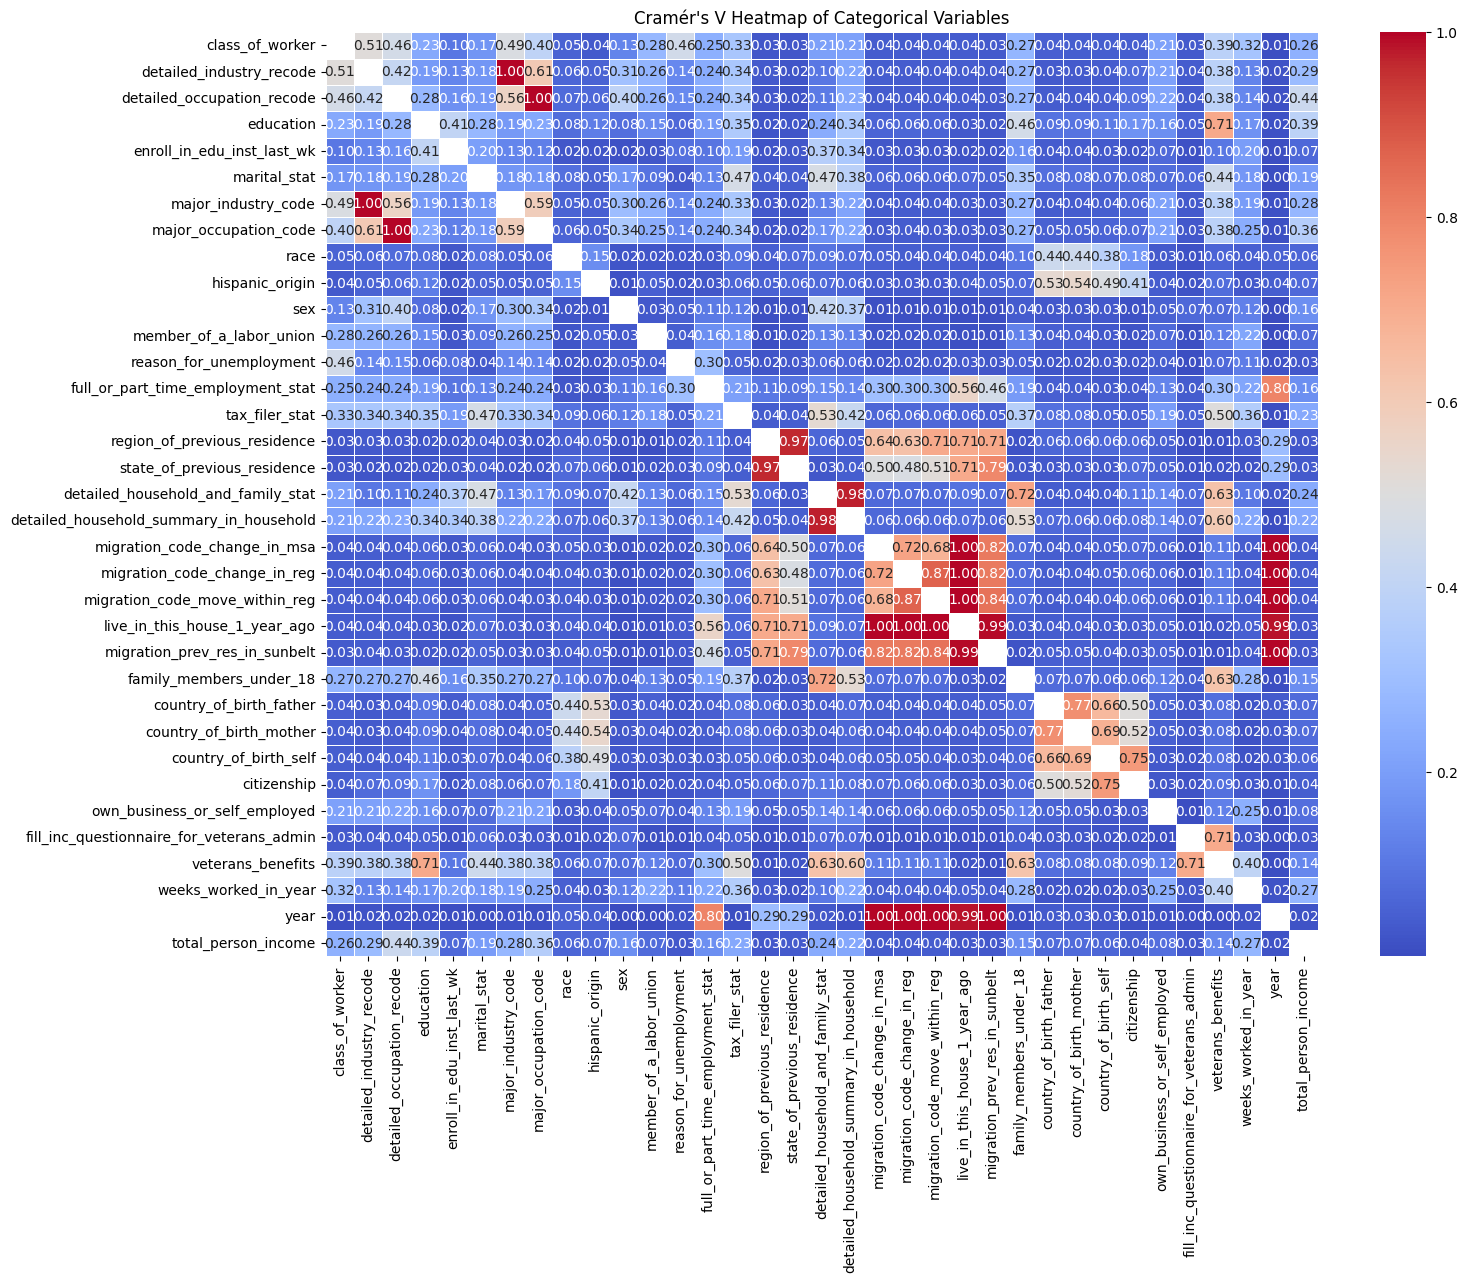

In [14]:
#Visualize correlation
variables = [pair.split(' vs ') for pair in correlation_df['Variable Pair']]
cramers_values = correlation_df["Cramér's V"]

cramers_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)


for idx, pair in enumerate(variables):
    var1, var2 = pair
    cramers_matrix.loc[var1, var2] = cramers_values.iloc[idx]
    cramers_matrix.loc[var2, var1] = cramers_values.iloc[idx]  # Symmetric matrix

cramers_matrix = cramers_matrix.astype(float)


plt.figure(figsize=(16, 12))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cramér's V Heatmap of Categorical Variables")
plt.show()


In [43]:
## Dropping Columns where the Correlation is 1, or higher than 0.7
to_drop = ['migration_code_change_in_msa',
           'migration_code_change_in_reg',
           'migration_code_move_within_reg',
          'migration_prev_res_in_sunbelt',
          'detailed_household_summary_in_household',
          'country_of_birth_father', 
           'country_of_birth_mother',
          'state_of_previous_residence',
          'family_members_under_18',
          'country_of_birth_self',
          'region_of_previous_residence',
          'year',
          'major_industry_code',
          'major_occupation_code',
          'veterans_benefits',
          'instance weight']

df_cleaned = full_data.drop(columns=to_drop)

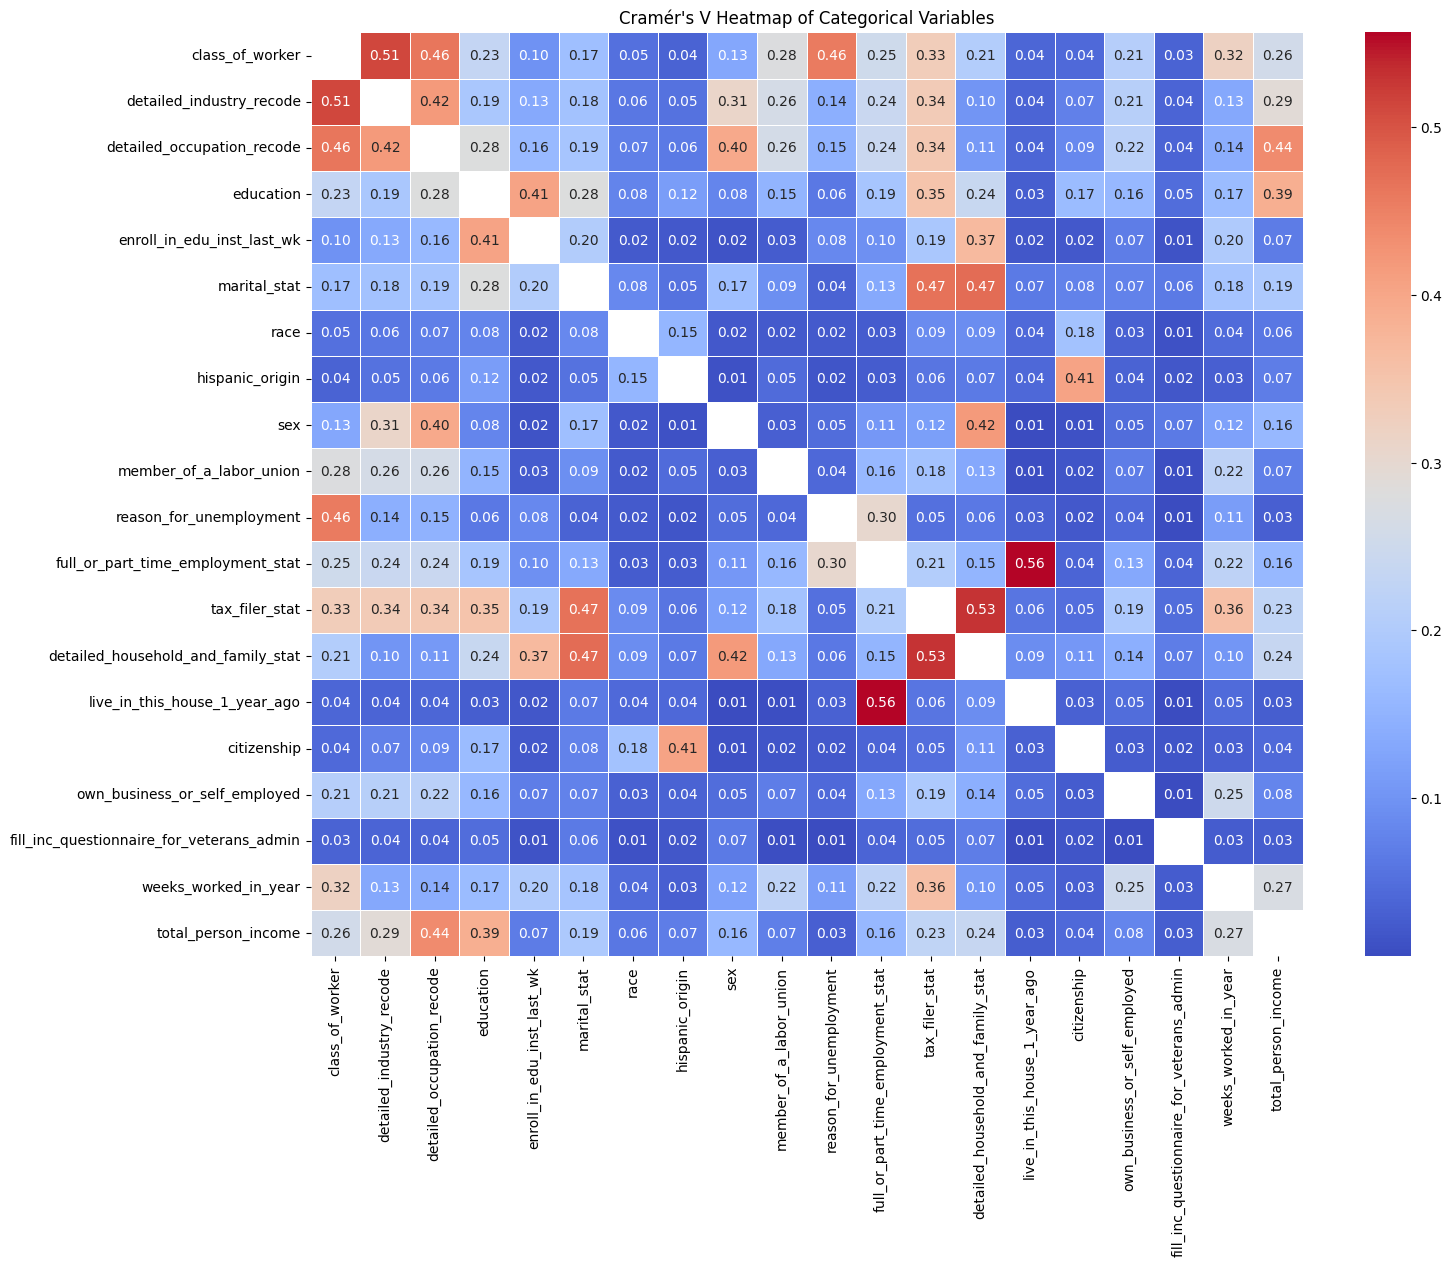

In [16]:
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

correlation_dict = {}

# Calculate correlation pairs
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        var1 = categorical_columns[i]
        var2 = categorical_columns[j]
        correlation = cramers_v(df_cleaned[var1], df_cleaned[var2])
        correlation_dict[f"{var1} vs {var2}"] = correlation

# Convert the dictionary to a DataFrame for easy viewing
correlation_df = pd.DataFrame(list(correlation_dict.items()), columns=["Variable Pair", "Cramér's V"])

variables = [pair.split(' vs ') for pair in correlation_df['Variable Pair']]
cramers_values = correlation_df["Cramér's V"]

# Create an empty DataFrame
cramers_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Fill the correlation matrix with the Cramér's V values
for idx, pair in enumerate(variables):
    var1, var2 = pair
    cramers_matrix.loc[var1, var2] = cramers_values.iloc[idx]
    cramers_matrix.loc[var2, var1] = cramers_values.iloc[idx]  # Symmetric matrix

# Convert the matrix to numeric type
cramers_matrix = cramers_matrix.astype(float)

# Visualize the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cramér's V Heatmap of Categorical Variables")
plt.show()

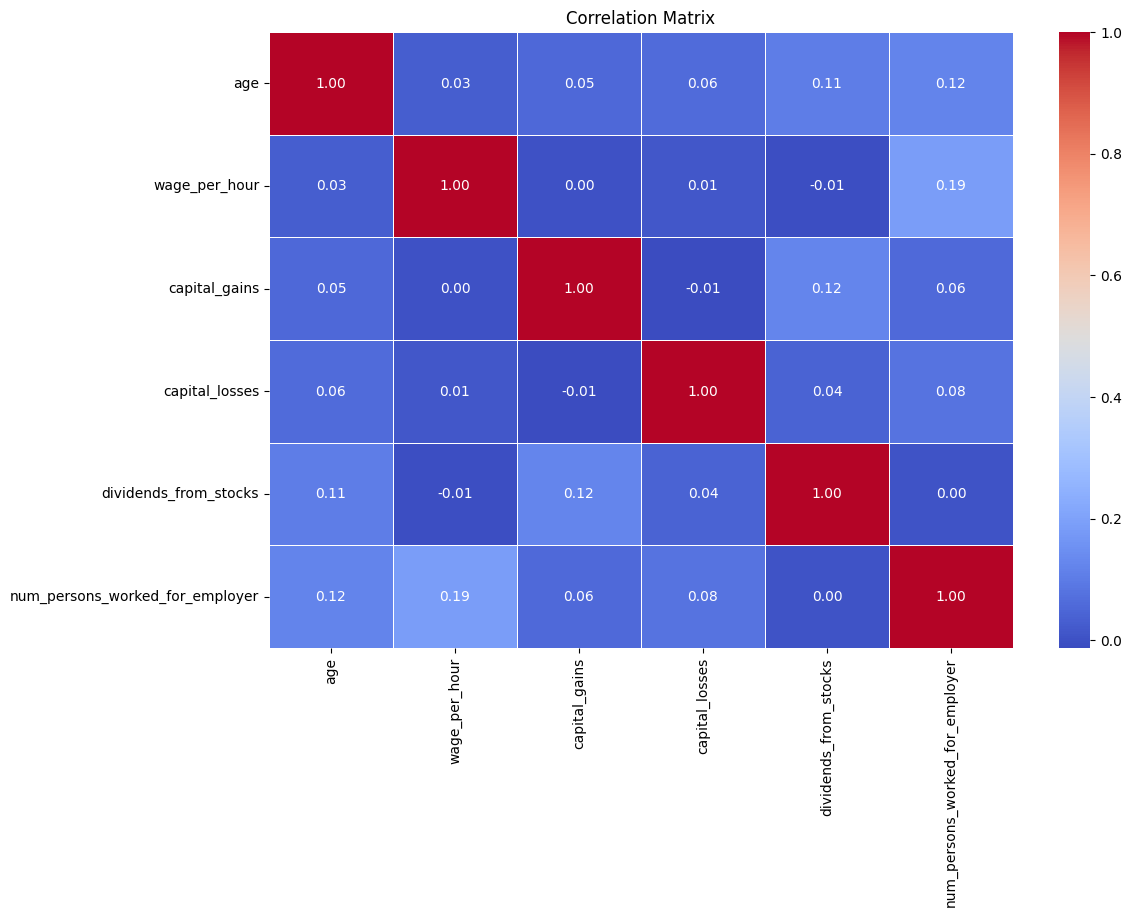

In [17]:
# Correlation matrix excluding categorical columns, only for numerical variables
numeric_df = df_cleaned.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### Creating a Pairplot Visualization

In [44]:
X = df_cleaned.drop(columns=['total_person_income'])  # Features
y = df_cleaned['total_person_income']

/opt/blue-python/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


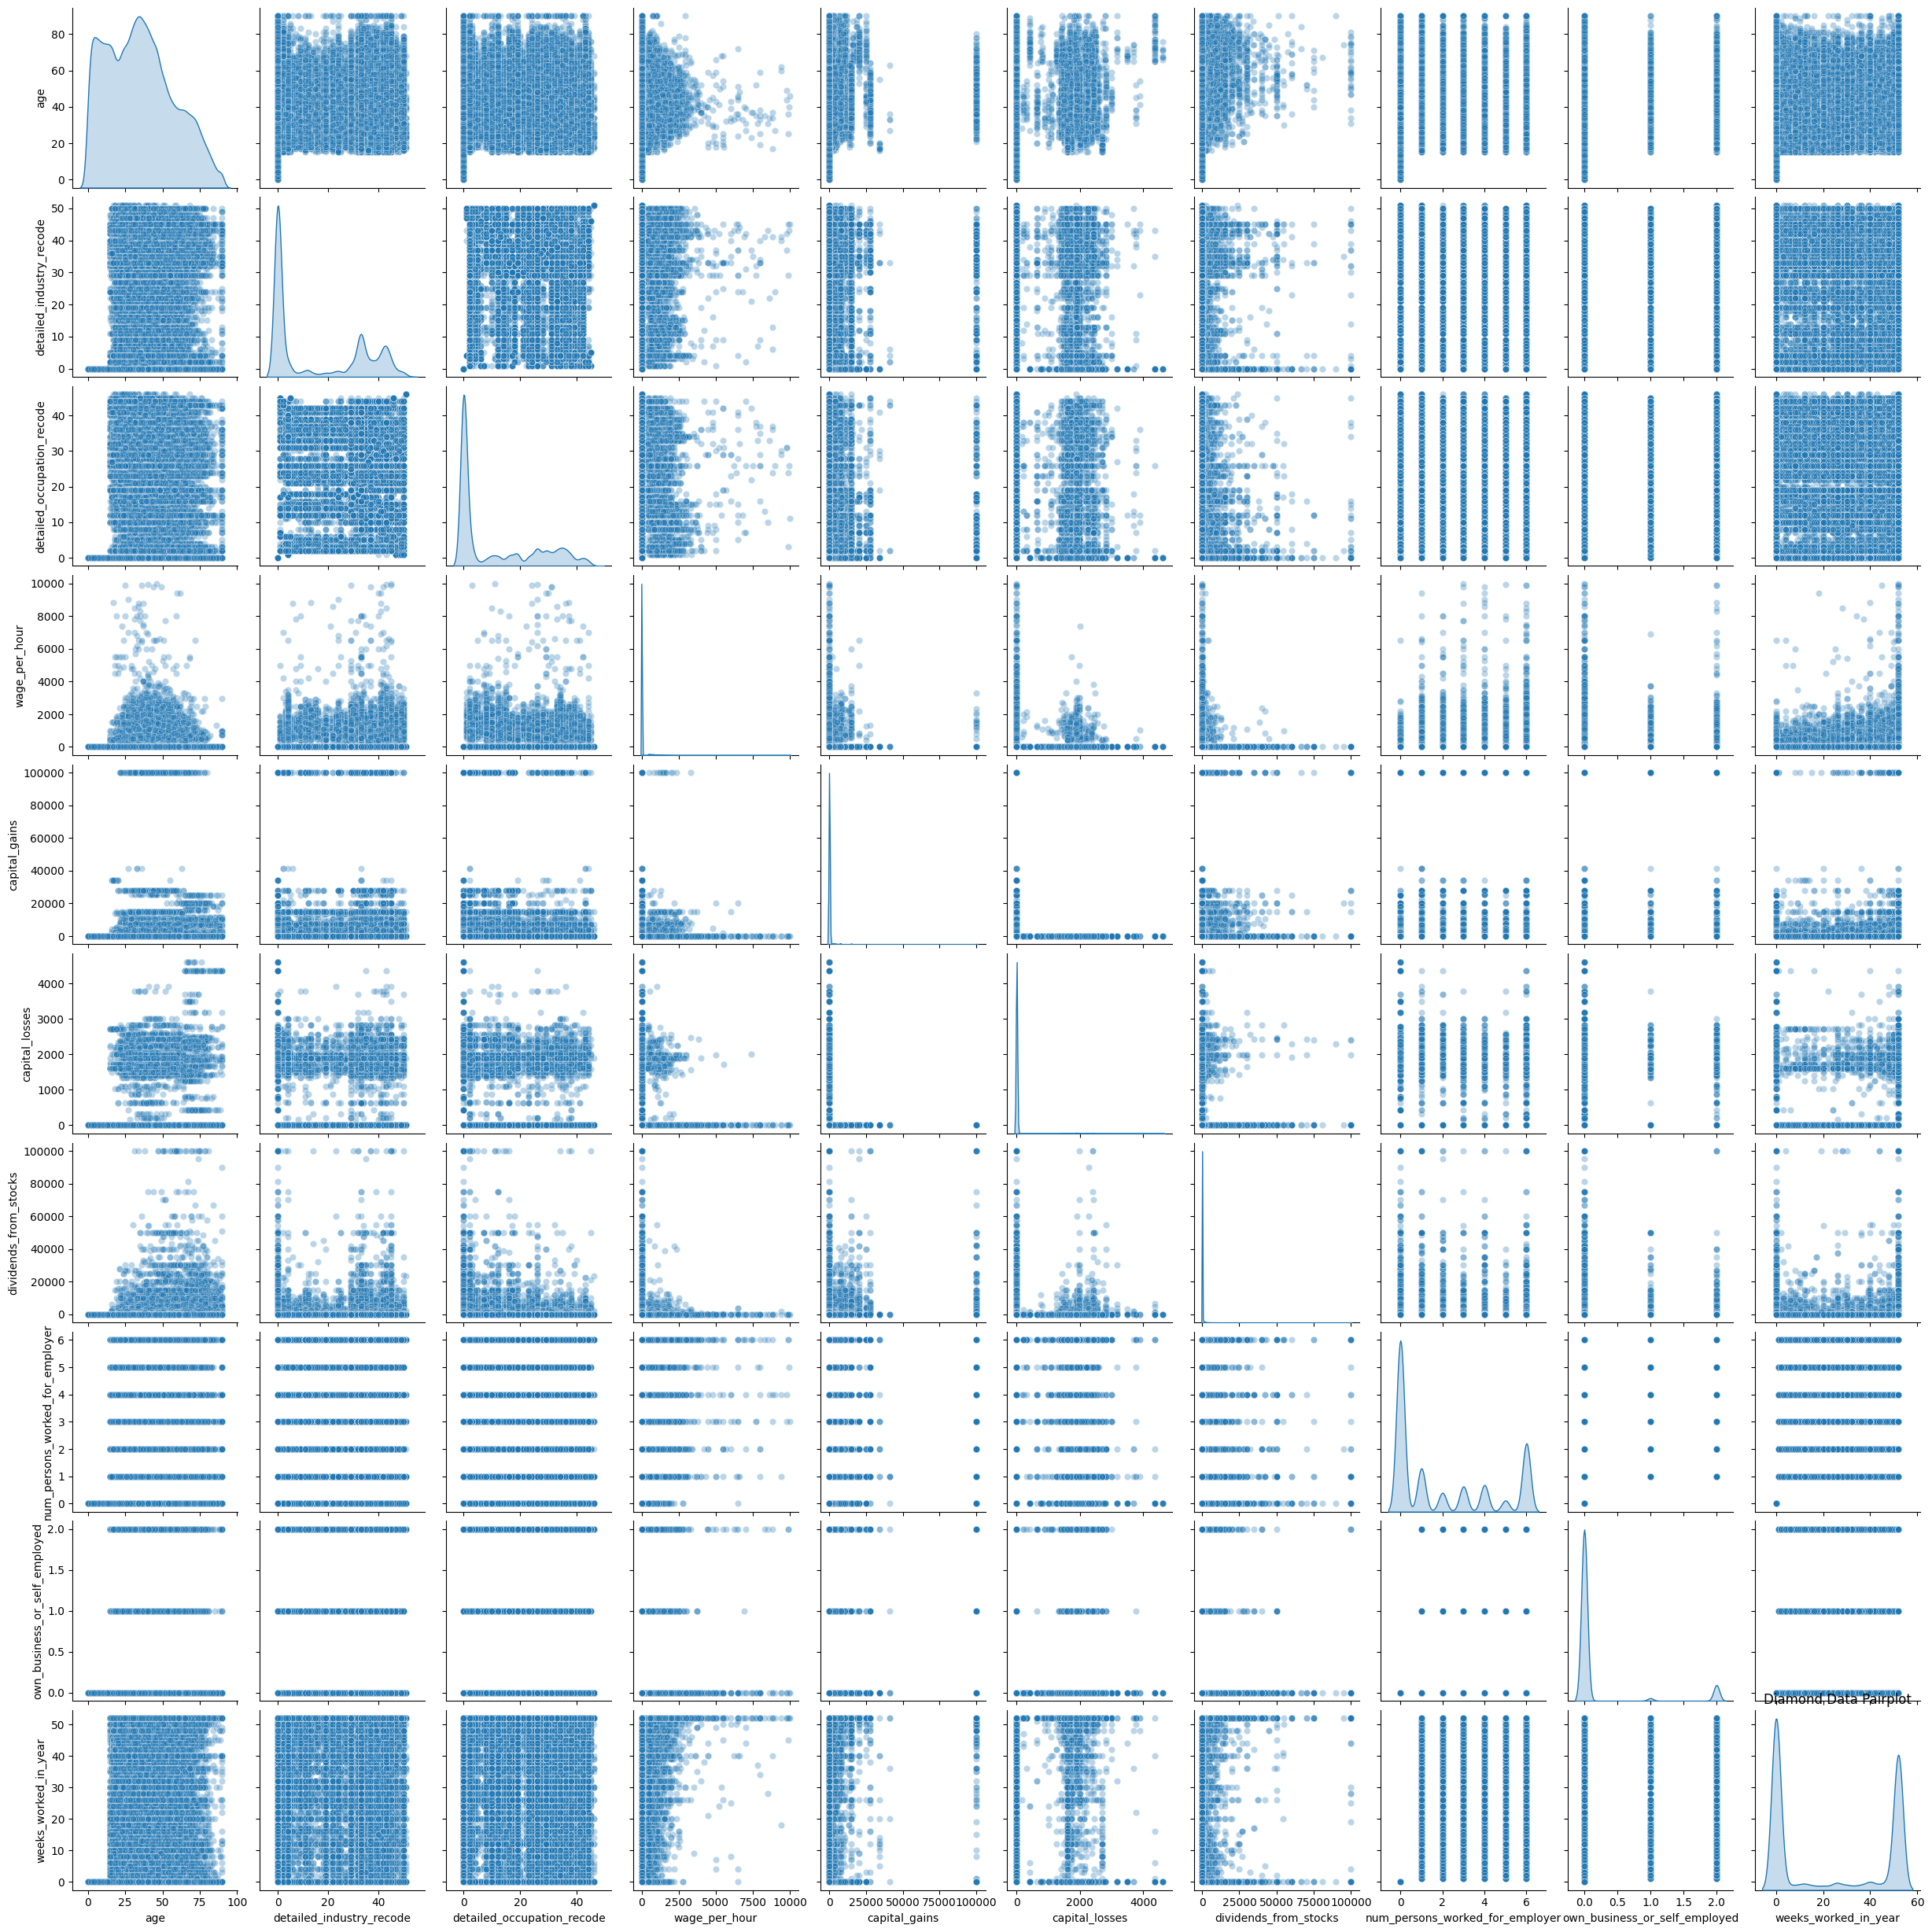

In [19]:
# Explore the dataset
df = pd.concat([X, y], axis=1)
# Basic visualization
sns.pairplot(df, diag_kind='kde',plot_kws={'alpha': 0.3})
plt.title('Pairplot')
plt.show()

### Numerical Features Analysis

In [20]:
print(df_cleaned.describe())
print("Target Variable Distribution:\n", y.value_counts())

                 age  wage_per_hour  capital_gains  capital_losses  \
count  292548.000000  292548.000000  292548.000000   292548.000000   
mean       35.148598      56.369533     441.684636       37.697595   
std        22.174939     276.335668    4723.778668      272.819932   
min         0.000000       0.000000       0.000000        0.000000   
25%        17.000000       0.000000       0.000000        0.000000   
50%        34.000000       0.000000       0.000000        0.000000   
75%        50.000000       0.000000       0.000000        0.000000   
max        90.000000    9999.000000   99999.000000     4608.000000   

       dividends_from_stocks  num_persons_worked_for_employer  
count          292548.000000                    292548.000000  
mean              200.323567                         2.000848  
std              1959.718392                         2.372973  
min                 0.000000                         0.000000  
25%                 0.000000                     

#### Wage, Income, and Capital Variables

##### Wage Per Hour:

The average wage is 56.34, but the standard deviation is 277.06, indicating a wide variation in hourly wages. The minimum wage is 0, suggesting there might be entries where the person isn't earning (or missing data).

A large proportion of the data may have wage_per_hour = 0, as indicated by the 25th, 50th, and 75th percentiles being zero.

##### Capital Gains
These have very large ranges (e.g., capital_gains max = 99,999), with a mean of 441.87 for capital_gains, but the standard deviation is quite high (4735.69), suggesting a few extreme values that could be outliers.

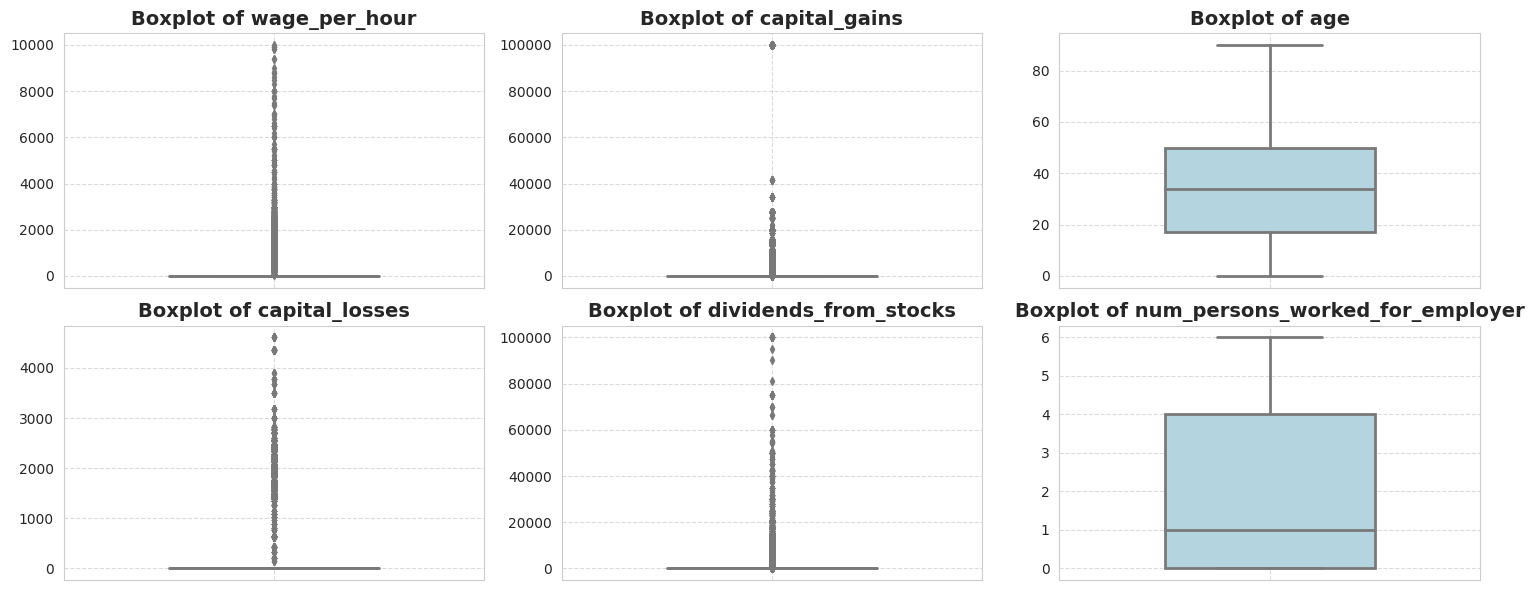

In [21]:
# Create Boxplots about numerical variables

sns.set_style("whitegrid")
features = ["wage_per_hour", "capital_gains","age","capital_losses","dividends_from_stocks","num_persons_worked_for_employer"]


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))  
axes = axes.flatten()  # Flatten the 2D array for easier iteration

# Create boxplots for each feature
for i, feature in enumerate(features):
    sns.boxplot(y=df_cleaned[feature], ax=axes[i], color="lightblue", width=0.5, linewidth=2, fliersize=4)
    axes[i].set_title(f"Boxplot of {feature}", fontsize=14, fontweight="bold")
    axes[i].set_ylabel("")  # Remove y-axis labels for cleaner look
    axes[i].grid(True, linestyle="--", alpha=0.7)  # Light grid for readability

plt.tight_layout()
plt.show()

### Wage per Hour
Since wage per hour can be a crucial variable to determine the target variable but it is clearly a right skrewed data

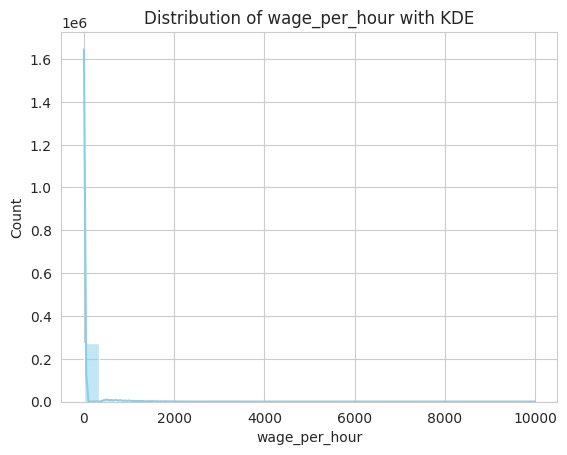

In [22]:
# Showing if the wage per hours are postively skewed

sns.histplot(df_cleaned['wage_per_hour'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of wage_per_hour with KDE')
plt.show()

#### Capital Gains

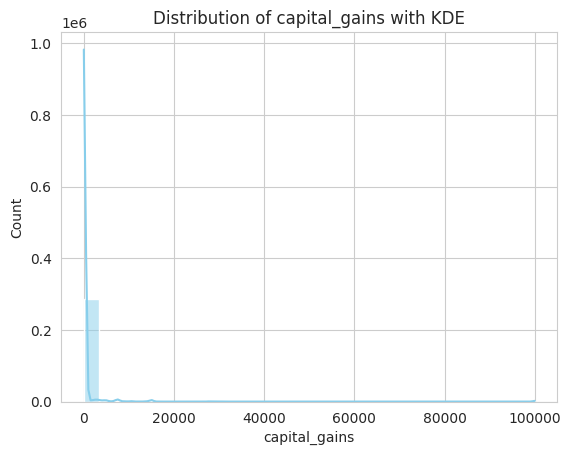

In [24]:
# Showing if the wage per hours are postively skewed
sns.histplot(df_copy['capital_gains'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of capital_gains with KDE')
plt.show()

### Capital losses

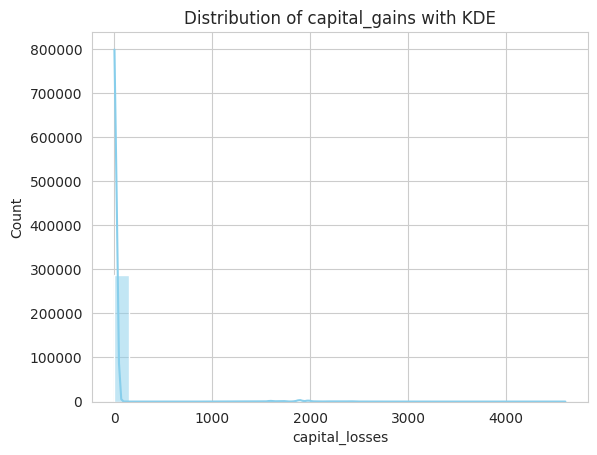

In [26]:
# Showing if the wage per hours are postively skewed
sns.histplot(df_copy['capital_losses'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of capital_gains with KDE')
plt.show()

### Dividends from Stocks

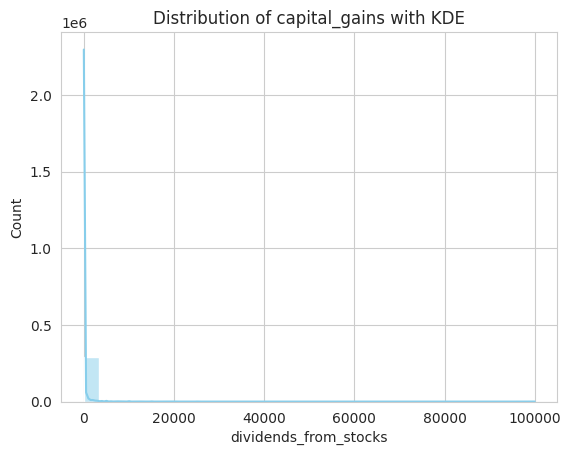

In [28]:
sns.histplot(df_copy['dividends_from_stocks'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of capital_gains with KDE')
plt.show()

## MODELLING

In [45]:
df_final=df_cleaned.copy()

In [46]:
df_final['total_person_income']= df_final['total_person_income'].str.replace(' ', '', regex=False)

In [47]:
df_final['income_class'] = np.where(df_final['total_person_income'] == '-50000.', 0, 1)

In [48]:
df_final_v1=df_final.drop(columns=['total_person_income'])

In [49]:
df_final_v1['income_class'] = df_final_v1['income_class'].astype('category')

In [50]:
X = df_final_v1.drop(columns=["income_class"])
y = df_final_v1["income_class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Random Forrest

In [51]:
#Define categorical features 
categorical_features=X_train.select_dtypes(include=['object', 'category']).columns.tolist()

#### Parameters,Encoding, Pipeline build up

In [52]:
onehotencoder = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # One-hot encode categorical variables
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', onehotencoder, categorical_features)
    ], 
    remainder='passthrough'  # Keep non-categorical columns as they are
)

rf = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

#setting the parameter Grid:
param_grid = {'classifier__n_estimators': [20, 30, 50],  # Example grid for n_estimators
              'classifier__max_depth': [5,10,15]}

#Fit the GridSearchCV to the K-NN model
grid_rf = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=1, verbose=1)

In [53]:
#Model Fit
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/blue-python/3.10/lib64/python3.10/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['class_of_worker',
                                                                          'education',
                                                                          'enroll_in_edu_inst_last_wk',
                                                                          'marital_stat',
                                                                          'race',
                                                                          'hispanic_origin',
                                                                          'sex',
                                                                          'member_of_a_labor_union',
                                                                          'reason_for_unemployment',
                                                                          'full_or_part_time_employment_stat',
                                                                          'tax_filer_stat',
                                                                          'detailed_household_and_family_stat',
                                                                          'live_in_this_house_1_year_ago',
                                                                          'citizenship',
                                                                          'fill_inc_questionnaire_for_veterans_admin'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [5, 10, 15],
                         'classifier__n_estimators': [20, 30, 50]},
             verbose=1)

#### Random Forest Model Evaluation

In [54]:
#Print the train set results 
print("best mean cross-validation score on the train data: {:.3f}".format(grid_rf.best_score_))
print("best parameters: {}".format(grid_rf.best_params_))

#Fit to the test set
print("test-set accuracy score: {:.3f}".format(grid_rf.score(X_test, y_test)))

# Evaluate the model on the test set
y_pred = grid_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

best mean cross-validation score on the train data: 0.952
best parameters: {'classifier__max_depth': 15, 'classifier__n_estimators': 30}
test-set accuracy score: 0.951
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     68481
           1       0.82      0.29      0.43      4656

    accuracy                           0.95     73137
   macro avg       0.89      0.64      0.70     73137
weighted avg       0.95      0.95      0.94     73137



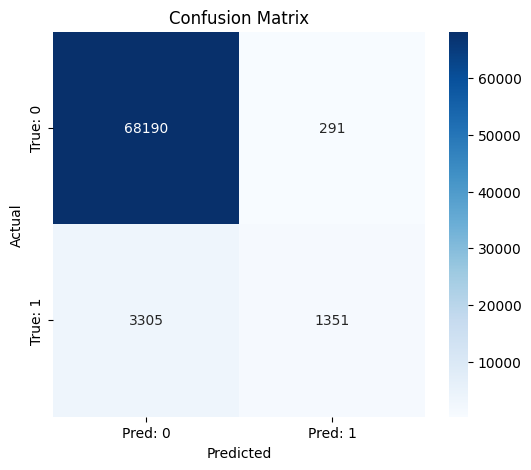

In [55]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [56]:
# Calculate Area Under the Curve

y_prob = grid_rf.predict_proba(X_test)[:, 1]

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9437975725802692


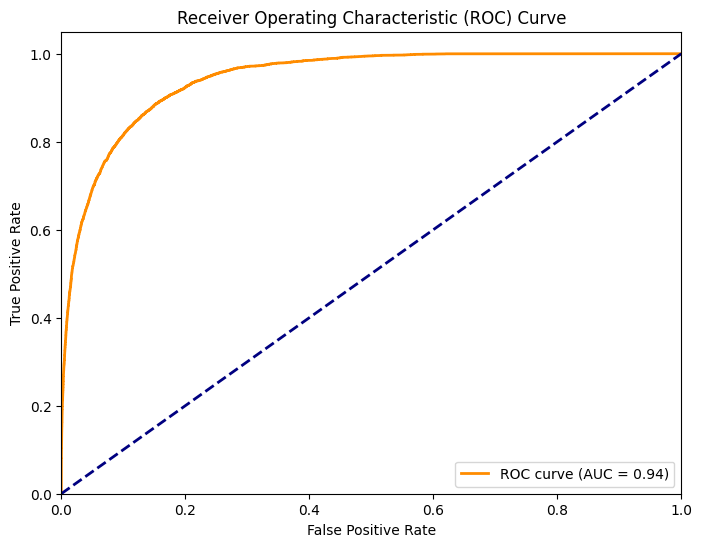

In [57]:
# Visualizing Area Under the Curve and ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Calculate Feature Importance

In [58]:
# Create a function which gives back the encoded feature names
def get_feature_names_from_column_transformer(column_transformer):
    output_features = []

    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop' or transformer is None:
            continue
        elif transformer == 'passthrough':
            if isinstance(columns, slice):
                raise ValueError("Can't handle slice passthrough yet.")
            output_features.extend(columns)
        else:
            try:
                if hasattr(transformer, 'get_feature_names_out'):
                    names = transformer.get_feature_names_out()
                    output_features.extend(names)
                else:
                    output_features.extend(columns)
            except Exception as e:
                print(f"Warning: could not get names from transformer '{name}': {e}")
                output_features.extend(columns)

    return output_features


In [59]:
# Fit preprocessor separately to extract transformed feature names
preprocessor.fit(X_train)
feature_names = get_feature_names_from_column_transformer(preprocessor)

In [60]:
best_model = grid_rf.best_estimator_

preprocessor = best_model.named_steps['preprocessor'] 
rf = best_model.named_steps['classifier']

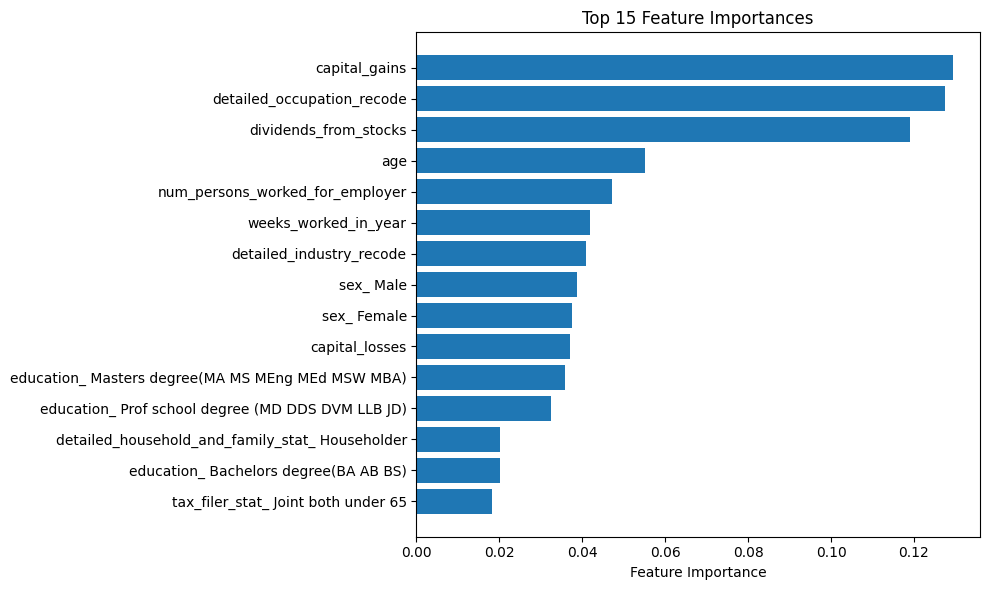

In [61]:
importances = rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:15][::-1], feat_imp_df['Importance'][:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

In [62]:
# Create a dataframe about feature importance and identify features with low importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.01]['Feature'].tolist()

In [63]:
#Retrain the model with reduved feature set

categorical_features=X_train.select_dtypes(include=['object', 'category']).columns.tolist()


categorical = [col for col in categorical_features if col not in low_importance_features]

onehotencoder = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # One-hot encode categorical variables
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', onehotencoder, categorical)
    ], 
    remainder='passthrough'  # Keep non-categorical columns as they are
)

rf = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])


param_grid = {'classifier__n_estimators': [20, 30, 50],  # Example grid for n_estimators
              'classifier__max_depth': [5,10,15]}


grid_rf = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=1, verbose=1)

grid_rf.fit(X_train, y_train)


print("best mean cross-validation score on the train data: {:.3f}".format(grid_rf.best_score_))
print("best parameters: {}".format(grid_rf.best_params_))


print("test-set accuracy score: {:.3f}".format(grid_rf.score(X_test, y_test)))


y_pred = grid_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
best mean cross-validation score on the train data: 0.952
best parameters: {'classifier__max_depth': 15, 'classifier__n_estimators': 30}
test-set accuracy score: 0.951
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     68481
           1       0.82      0.29      0.43      4656

    accuracy                           0.95     73137
   macro avg       0.89      0.64      0.70     73137
weighted avg       0.95      0.95      0.94     73137



In [64]:
# Check the AUC score with lower feature set
y_prob = grid_rf.predict_proba(X_test)[:, 1]

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9437975725802692


### CatBoost Model

In [65]:
# setting cross validation with Stratified KFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Parameters,Encoding, Pipeline build up

In [66]:
categorical_features=X_train.select_dtypes(include=['object', 'category']).columns.tolist()

catboost = CatBoostClassifier(verbose=0, random_state=42)

pipeline = Pipeline(steps=[
    ('classifier', catboost)
])

# GridSearchCV parameter grid for CatBoost
param_grid = {
    'classifier__depth': [4, 6],
    'classifier__learning_rate': [0.03, 0.1]
}

# Run GridSearchCV
grid_catboost = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=1, verbose=1)

In [67]:
#Model Fit
grid_catboost.fit(X_train, y_train, classifier__cat_features=categorical_features)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        <catboost.core.CatBoostClassifier object at 0x7fa03670df30>)]),
             n_jobs=1,
             param_grid={'classifier__depth': [4, 6],
                         'classifier__learning_rate': [0.03, 0.1]},
             verbose=1)

#### Model Evaluation 

In [68]:
# Print the results
print("Best mean cross-validation score on the train data: {:.3f}".format(grid_catboost.best_score_))
print("Best parameters: {}".format(grid_catboost.best_params_))

# Test set evaluation
print("Test-set accuracy score: {:.3f}".format(grid_catboost.score(X_test, y_test)))

# Classification report
y_pred = grid_catboost.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Best mean cross-validation score on the train data: 0.958
Best parameters: {'classifier__depth': 6, 'classifier__learning_rate': 0.1}
Test-set accuracy score: 0.957
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     68481
           1       0.76      0.48      0.59      4656

    accuracy                           0.96     73137
   macro avg       0.86      0.73      0.78     73137
weighted avg       0.95      0.96      0.95     73137



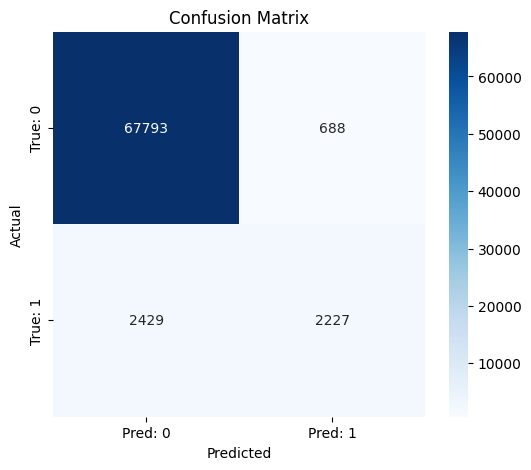

In [69]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [70]:
#Calculate AUC Score
y_prob = grid_catboost.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9548491492811786


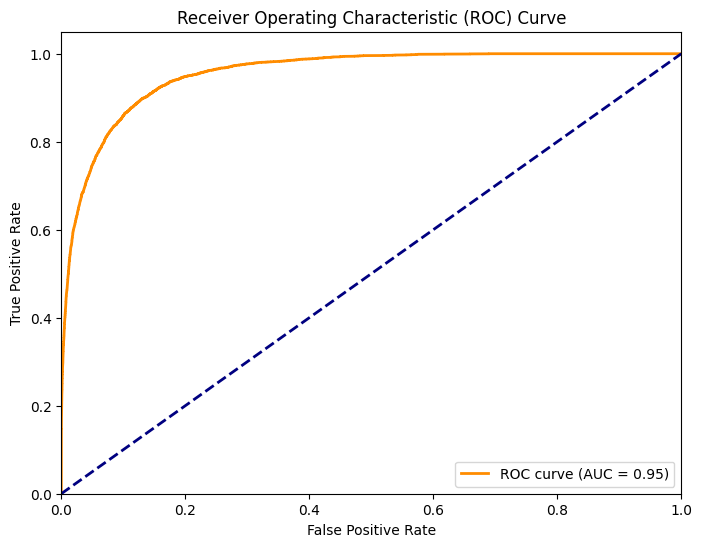

In [73]:
#Visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Get Feature Importance

In [74]:
best_model = grid_catboost.best_estimator_
cat_model = best_model.named_steps['classifier']

In [75]:
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)

In [76]:
importances = cat_model.get_feature_importance(train_pool)

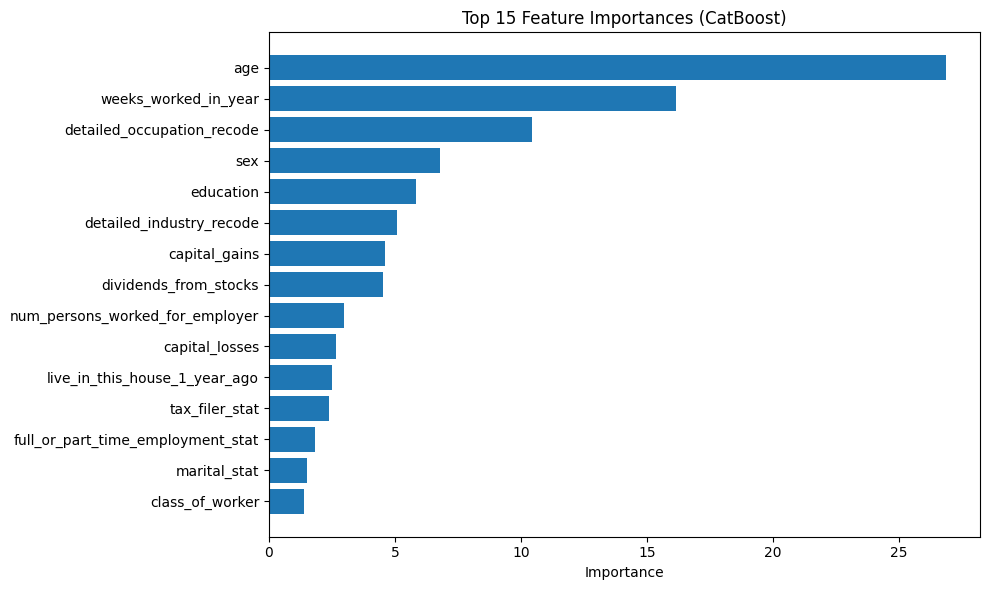

In [77]:
feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:15][::-1], feat_imp_df['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (CatBoost)")
plt.tight_layout()
plt.show()
